In [1]:
import numpy as np
import scipy
import matplotlib
import snpy
import os
import matplotlib.pyplot as plt         #import modules
import emcee
import corner
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u

clight = 299792.458     #speed of light in kms-1

In [2]:
#Add required functions
def splitter(direct,group):  #takes a collection (direct) of SN with its data and removes all SN in (group). 
    rem_group=[]
    cut_group=[]
    for i in range(0,len(direct)):
        if direct[i][0] in group:
            cut_group+=[direct[i]]
        else:
            rem_group+=[direct[i]]
    return rem_group, cut_group

def plane(direct):  #formats collection (direct) of SN into 4 separate lists of: SN, z, Jmax, err_Jmax for use in plotting
    sn=[]
    red_shift=[]
    Jmax=[]
    err_Jmax=[]
    for i in range(0,len(direct)):
        sn+=[direct[i][0]]
        red_shift+=[direct[i][1]]
        Jmax+=[direct[i][2]]
        err_Jmax+=[direct[i][3]]
    return sn, red_shift, Jmax, err_Jmax

def low_red(direct,value): #Takes a collection (direct) of SN and removes all SN from (direct) with z<value
    sn_lred=[]
    for i in range(0,len(direct)):
        if direct[i][1]<value:
            sn_lred+=[direct[i][0]]
    return sn_lred

def model_function(x_vals,aj):  #model function from Dhawan 2018 with q0 and j0 set as fixed constants
    q0=-0.55
    j0=1
    return 5*(np.log10(3e5*x_vals)+np.log10(1+((1-q0)*x_vals/2)-((1-q0-3*(q0**2)+j0)*(x_vals**2)/6))-aj)

def pec_vel_err(redshift, sigma_pec):  #peculiar velocity error for a given sigma_pec (usually 150 or 250)
    return (5/np.log(10))*sigma_pec/(299792.458*np.array(redshift))

#contains parts of code from Suhail's github repo at https://github.com/sdhawan21/irh0
def distmod70(z):  #calculates DM value assuming H0=70
        q0 = -0.55
        j0 = 1.0
        return 5.0 * np.log10(299792.458*z/70.0 *
                              (1 + (1 - q0)*z/2.0 
                               - (1 - q0 - 3*q0**2 + j0)*(z**2)/6.0)) + 25.0


#contains parts of code from Suhail's github repo at https://github.com/sdhawan21/irh0
def log_prior(theta): #prior function for mcmc
        H0, M, sigma = theta
        return -np.log(sigma) if (sigma>0 and H0>0) else -np.inf

#contains parts of code from Suhail's github repo at https://github.com/sdhawan21/irh0
def log_likelihood(theta, calib_absM, calib_err, hflow_absM70, hflow_err): #likelihood function for mcmc
    H0, M, sigma = theta
    sigma2 = sigma
    calib_vartot = calib_err**2 + sigma**2 
    calib_loglike = -0.5 * (np.sum(np.log(2 * np.pi * calib_vartot) + (calib_absM - M)**2 / calib_vartot))
    #pass in the Hubble flow data as the absolute magnitude assuming H0=70
    hflow_vartot = hflow_err**2 + sigma2**2  
    h70mag = 5.0 * np.log10(H0/70)
    hflow_loglike = -0.5 * (np.sum(np.log(2 * np.pi * hflow_vartot) + (hflow_absM70 - M + h70mag)**2 / hflow_vartot))

    return calib_loglike + hflow_loglike

#contains parts of code from Suhail's github repo at https://github.com/sdhawan21/irh0
def log_probability(theta, calib_absM, calib_err, hflow_absM70, hflow_err): #posterior function for mcmc
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, calib_absM, calib_err, hflow_absM70, hflow_err)

In [3]:
#The following assumes all data is within one directory; the same as this notebook.
#If data is split then modify os.listdir().
#In this format CSP and CALIBRATORS will be loaded together but these are separated later.

In [4]:
#EBV_model2 fits
#collects data from .snpy files and extracts the SN.ID, z, Jmax and err_Jmax
sn_dir_EBV=[]      #collection of data for RATIR
for file in os.listdir():
    if file.endswith("EBV2_RAT.snpy"):
        items=[]
        s=snpy.get_sn(file)
        items+=[file[0:5],s.z]
        if "J" in s.restbands:  #filter order is deduced from fringe filters, in most cases Jspm is only filter
            items+=[s.get_max("J",restframe=1)[1]-s.EBVgal*0.81,s.get_max("J",restframe=1)[2]]
        elif "Jspm_AB" in s.restbands:
            items+=[s.get_max("Jspm_AB",restframe=1)[1]-s.EBVgal*0.81,s.get_max("Jspm_AB",restframe=1)[2]]
        elif "Jnot" in s.restbands:
            items+=[s.get_max("Jnot",restframe=1)[1]-s.EBVgal*0.81,s.get_max("Jnot",restframe=1)[2]]
        elif "HAWKIJ" in s.restbands:
            items+=[s.get_max("HAWKIJ",restframe=1)[1]-s.EBVgal*0.81,s.get_max("HAWKIJ",restframe=1)[2]]
        elif "J2m" in s.restbands:
            items+=[s.get_max("J2m",restframe=1)[1]-s.EBVgal*0.81,s.get_max("J2m",restframe=1)[2]]
        elif "Jrc2" in s.restbands:
            items+=[s.get_max("Jrc2",restframe=1)[1]-s.EBVgal*0.81,s.get_max("Jrc2",restframe=1)[2]]
        elif "Jspm" in s.restbands:
            items+=[s.get_max("Jspm",restframe=1)[1]-s.EBVgal*0.81,s.get_max("Jspm",restframe=1)[2]]
        sn_dir_EBV+=[items]

CSP_dir_EBV=[]        #collection of data for CSP+CALIBRATORS (if in same directory)
        
for file in os.listdir():
    if file.endswith("EBV2.snpy"):
        items=[]
        s=snpy.get_sn(file)
        items+=[file[0:4],s.z]
        if "Jrc2" in s.restbands:
            items+=[s.get_max("Jrc2",restframe=1)[1]-s.EBVgal*0.81,s.get_max("Jrc2",restframe=1)[2]]
        elif "J" in s.restbands:
            items+=[s.get_max("J",restframe=1)[1]-s.EBVgal*0.81,s.get_max("J",restframe=1)[2]]
        elif "J2m" in s.restbands:
            items+=[s.get_max("J2m",restframe=1)[1]-s.EBVgal*0.81,s.get_max("J2m",restframe=1)[2]]
        elif "J_P" in s.restbands:
            items+=[s.get_max("J_P",restframe=1)[1]-s.EBVgal*0.81,s.get_max("J_P",restframe=1)[2]]
        elif "WHIRCJ" in s.restbands:
            items+=[s.get_max("WHIRCJ",restframe=1)[1]-s.EBVgal*0.81,s.get_max("WHIRCJ",restframe=1)[2]]
        CSP_dir_EBV+=[items]
        
#format  [SN identifications, redshift, Jmax, err_Jmax]

In [5]:
#EBV_model2 fits
#collects data from .snpy files and extracts the SN.ID, z, Jmax and err_Jmax
sn_dir_MAX=[]    #collection of data for RATIR

for file in os.listdir():
    if file.endswith("MAX_RAT.snpy"):
        items=[]
        s=snpy.get_sn(file)
        items+=[file[0:5],s.z]
        if "J" in s.restbands:   #filter order is deduced from fringe filters, in most cases Jspm is only filter
            items+=[s.get_max("J",restframe=1)[1]-s.EBVgal*0.81,s.get_max("J",restframe=1)[2]]
        elif "Jspm_AB" in s.restbands:
            items+=[s.get_max("Jspm_AB",restframe=1)[1]-s.EBVgal*0.81,s.get_max("Jspm_AB",restframe=1)[2]]
        elif "Jnot" in s.restbands:
            items+=[s.get_max("Jnot",restframe=1)[1]-s.EBVgal*0.81,s.get_max("Jnot",restframe=1)[2]]
        elif "HAWKIJ" in s.restbands:
            items+=[s.get_max("HAWKIJ",restframe=1)[1]-s.EBVgal*0.81,s.get_max("HAWKIJ",restframe=1)[2]]
        elif "J2m" in s.restbands:
            items+=[s.get_max("J2m",restframe=1)[1]-s.EBVgal*0.81,s.get_max("J2m",restframe=1)[2]]
        elif "Jrc2" in s.restbands:
            items+=[s.get_max("Jrc2",restframe=1)[1]-s.EBVgal*0.81,s.get_max("Jrc2",restframe=1)[2]]
        elif "Jspm" in s.restbands:
            items+=[s.get_max("Jspm",restframe=1)[1]-s.EBVgal*0.81,s.get_max("Jspm",restframe=1)[2]]
        sn_dir_MAX+=[items]
        
CSP_dir_MAX=[]        #collection of data for CSP+CALIBRATORS (if in same directory)
        
for file in os.listdir():
    if file.endswith("JandT.snpy"):
        items=[]
        s=snpy.get_sn(file)
        items+=[file[0:4],s.z]
        if "Jrc2" in s.restbands:
            items+=[s.get_max("Jrc2",restframe=1)[1]-s.EBVgal*0.81,s.get_max("Jrc2",restframe=1)[2]]
        elif "J" in s.restbands:
            items+=[s.get_max("J",restframe=1)[1]-s.EBVgal*0.81,s.get_max("J",restframe=1)[2]]
        elif "J2m" in s.restbands:
            items+=[s.get_max("J2m",restframe=1)[1]-s.EBVgal*0.81,s.get_max("J2m",restframe=1)[2]]
        elif "J_P" in s.restbands:
            items+=[s.get_max("J_P",restframe=1)[1]-s.EBVgal*0.81,s.get_max("J_P",restframe=1)[2]]
        elif "WHIRCJ" in s.restbands:
            items+=[s.get_max("WHIRCJ",restframe=1)[1]-s.EBVgal*0.81,s.get_max("WHIRCJ",restframe=1)[2]]
        CSP_dir_MAX+=[items]

        

#format  [SN identifications, redshift, Jmax, err_Jmax]

In [6]:
#RATIR SN labels include improper punctiation so are modified to be recognised by the mass file 
sn_old_name=['13ft.','14yy.','14jj_','13ez.','13s.s'] #old names to be changes
sn_new_name=['13ft','14yy','14jj','13ez','13s']       #desired new name

for i in range(0,len(sn_dir_EBV)):
    for k in range(0,len(sn_old_name)):
        if sn_dir_EBV[i][0]==sn_old_name[k]: #changes names in EBV collection
            sn_dir_EBV[i][0]=sn_new_name[k]

for i in range(0,len(sn_dir_MAX)):
    for k in range(0,len(sn_old_name)):
        if sn_dir_MAX[i][0]==sn_old_name[k]: #changes names in MAX collection
            sn_dir_MAX[i][0]=sn_new_name[k]



In [7]:
#For SN with one letter e.g. 09I_ the _ is removed to be recognised by the mass file
for i in range(0,len(CSP_dir_EBV)):
    if CSP_dir_EBV[i][0].endswith("_"): #changes ending for EBV collection
        booya=CSP_dir_EBV[i][0]
        CSP_dir_EBV[i][0]=booya[0:3]
        
for i in range(0,len(CSP_dir_MAX)):
    if CSP_dir_MAX[i][0].endswith("_"): #changes ending for MAX collection
        booya=CSP_dir_MAX[i][0]
        CSP_dir_MAX[i][0]=booya[0:3]

In [8]:
tot_dir_EBV=sn_dir_EBV+CSP_dir_EBV   #combined collection of SN from CSP,CALIBRATORS and RATIR for each model
tot_dir_MAX=sn_dir_MAX+CSP_dir_MAX

In [9]:
file="nir_samples_hostmasses.dat"
  
# opening a text file
file1 = open(file, "r")
  
sn_mass=[]
mass_val=[]

# Loop through the file line by line
for line in file1: 
    for q in range(0,len(tot_dir_MAX)):  
        if tot_dir_MAX[q][0] in line:    #reading the file to find the SN that have mass data
            try:
                xtry=float(line[-6:-1])
                if 0<xtry<3:               #Some masses are given to 3 decimal places so 11.345 will read as 1.345
                    mass_val+=[xtry+10]    #For these SN they are correctly modified
                else:
                    mass_val+=[xtry]          
                sn_mass+=[tot_dir_MAX[q][0]]  #sn_mass contains list of all SN with mass values in mass_val
            except ValueError:
                tally=0

In [10]:
sn_high_mass=[]
mass_val_high=[]   #splits list into all 'high' mass values and all 'low' mass values 
sn_low_mass=[]
mass_val_low=[]
for i in range(0,len(sn_mass)):
    if 10<mass_val[i]<20:      #20 limit is to stop random values of 99 being in sample
        sn_high_mass+=[sn_mass[i]]
        mass_val_high+=[mass_val[i]]
    elif 3<mass_val[i]<10:        #3 limit is to stop negative errores values or wrongly read values being in sample
        sn_low_mass+=[sn_mass[i]]
        mass_val_low+=[mass_val[i]]

In [11]:
low_red_EBV=low_red(tot_dir_EBV,0.01) #list of SN with z<0.01
low_red_MAX=low_red(tot_dir_MAX,0.01)

tot_high_red_EBV=splitter(tot_dir_EBV,low_red_EBV)[0] #cuts low redshift SN out, so gets rid of calibrators from hflow
tot_low_red_EBV=splitter(tot_dir_EBV,low_red_EBV)[1]

tot_high_red_MAX=splitter(tot_dir_MAX,low_red_MAX)[0]
tot_low_red_MAX=splitter(tot_dir_MAX,low_red_MAX)[1]

In [12]:
#list of SN to be cut from each sample
sbv_low_RAT=['13ahk','13dym']  #sbv<0.5 for RATIR, determined from EBV_model2 sbv values
ebv_high_RAT=['14aje','13ahk'] #EBV>0.5 for RATIR, determined from COLOR EBV_model2 EBVhost values

#For RATIR we do not cut poor visual fits or low observations due to the smaller sample size

poor_fit_EBV_CSP=['06bd','05A','06br','05hj','09F','08hu','05ag','05na','07jd'] #CSP SN identified as having poor visual light curve fits
poor_fit_MAX_CSP=['06bd','06br','08bi','08hu','05na','05ag','07jd'] #Same for MAX_model fittings
low_obs_CSP=['05ag', '06ob', '08bi', '06ej', '04gu', '08O', '08cf', '05na', '08hu', '05am', '07jd', '08fu', '08bt', '09le']
#SN with less than 5 J-band observations in CSP
EBVhigh_CSP=['05A','06X','06br','07bm','08fp','09I'] #EBV>0.5 for CSP, taken from Burns et al 2018
Sbvlow_CSP=['05bl','05ke','06bd','06mr','07N','07al','07ax','08bi','08bt','09F'] #sbv<0.5 for CSP, taken from Burns et al 2018

#total list of SN to be cut for good fitting SN only
removed_sn_EBV=sbv_low_RAT+ebv_high_RAT+low_obs_CSP+EBVhigh_CSP+Sbvlow_CSP+poor_fit_EBV_CSP
removed_sn_MAX=sbv_low_RAT+ebv_high_RAT+low_obs_CSP+EBVhigh_CSP+Sbvlow_CSP+poor_fit_MAX_CSP

tot_good_fit_EBV=splitter(tot_high_red_EBV,removed_sn_EBV)[0] #removing these SN from collection
tot_good_fit_MAX=splitter(tot_high_red_MAX,removed_sn_MAX)[0]

In [13]:
#cutting remaining collection of good fits by mass
RAT_high_mass_EBV=splitter(splitter(tot_good_fit_EBV,plane(sn_dir_EBV)[0])[1],sn_high_mass)[1]
RAT_low_mass_EBV=splitter(splitter(tot_good_fit_EBV,plane(sn_dir_EBV)[0])[1],sn_low_mass)[1]  #for EBV_model
CSP_high_mass_EBV=splitter(splitter(tot_good_fit_EBV,plane(sn_dir_EBV)[0])[0],sn_high_mass)[1]
CSP_low_mass_EBV=splitter(splitter(tot_good_fit_EBV,plane(sn_dir_EBV)[0])[0],sn_low_mass)[1]

RAT_high_mass_MAX=splitter(splitter(tot_good_fit_MAX,plane(sn_dir_MAX)[0])[1],sn_high_mass)[1]
RAT_low_mass_MAX=splitter(splitter(tot_good_fit_MAX,plane(sn_dir_MAX)[0])[1],sn_low_mass)[1]   #for MAX_model
CSP_high_mass_MAX=splitter(splitter(tot_good_fit_MAX,plane(sn_dir_MAX)[0])[0],sn_high_mass)[1]
CSP_low_mass_MAX=splitter(splitter(tot_good_fit_MAX,plane(sn_dir_MAX)[0])[0],sn_low_mass)[1]

In [14]:
file="CAL_DM"    #file contains distance moduli with errors for 15 calibrator SN with J-band data
  
# opening a text file
file1 = open(file, "r")
  
sn_ceph=[]
DM=[]
err_DM=[]
tally=0

# Loop through the file line by line
for line in file1:
    tally+=1
    if tally!=1:
        if line[3]==' ':
            sn_ceph+=[str(line[0:3])] #list of SN with cepheid DM data
        else:
            sn_ceph+=[str(line[0:4])] 
        DM+=[float(line[5:10])]      #Distance modulus value
        err_DM+=[float(line[11:15])]

In [15]:
#calculates Absolute magnitudes for calibrator SN using fitting data and DM data
abs_magzz_EBV=[]
abs_magzz_err_EBV=[]
for i in range(0, len(sn_ceph)):
    for k in range(0, len(tot_dir_EBV)):
        if tot_dir_EBV[k][0]==sn_ceph[i]:
            abs_magzz_EBV+=[tot_dir_EBV[k][2]-DM[i]]
            abs_magzz_err_EBV+=[np.sqrt(tot_dir_EBV[k][3]**2 + err_DM[i]**2)] 
            
abs_magzz_MAX=[]
abs_magzz_err_MAX=[]
for i in range(0, len(sn_ceph)):
    for k in range(0, len(tot_dir_MAX)):
        if tot_dir_MAX[k][0]==sn_ceph[i]:
            abs_magzz_MAX+=[tot_dir_MAX[k][2]-DM[i]]
            abs_magzz_err_MAX+=[np.sqrt(tot_dir_MAX[k][3]**2 + err_DM[i]**2)] 

In [16]:
#contains parts of code from Suhail's github repo at https://github.com/sdhawan21/irh0
#Start of MCMC fitting, this shows CSP MAX model high masses being fitted
pecvel_unc=150.0 #sigma_pec in kms-1, usually 150 or 250
inputs=CSP_high_mass_MAX   #inputs is the hubble flow collection being used for this MCMC fitting

calib_data=np.array(abs_magzz_MAX) #calibrator absolute magnitudes, change if using EBV!
calib_unc=np.array(abs_magzz_err_MAX)  #calibrator absolute magnitude errors, change if using EBV!
hflow_data = np.array(plane(inputs)[2]) #Jmax values for sample being fitted
hflow_ptunc = np.array(plane(inputs)[3])#error in Jmax values for sample being fitted
hflow_zobs = np.array(plane(inputs)[1]) #redshift values for sample being fitted
hflow_zerr = 0  #redshift errors, this notebook assumes no data for this so uses zero

hflow_verr = hflow_zerr * clight
hflow_totverr = np.sqrt(hflow_verr**2 + pecvel_unc**2)
hflow_totzerr = hflow_totverr / clight  #error propagation for tot redshift error

hflow_pvmagerr = np.array(pec_vel_err(hflow_zobs, pecvel_unc))
hflow_unc = np.sqrt(hflow_ptunc**2 + hflow_pvmagerr**2) #goes from redshift to magnitude errors

hflow_mu70 = distmod70(hflow_zobs)
hflow_M70 = hflow_data - hflow_mu70 #Distance moduli from hubble plot to be used in likelihood function

In [17]:
#uses same conditions as Suhail's github repo at https://github.com/sdhawan21/irh0
ndim = 3  # number of parameters in the model
nwalkers = 200  # number of MCMC walkers
nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 2000

In [18]:
#uses same initital guess as Suhail's github repo at https://github.com/sdhawan21/irh0
guess = np.zeros(3)
scale = np.ones(3)

# first is H0 (km/s/Mpc)
guess[0] = 70.0
scale[0] = 10.0

# second is M (mag)
guess[1] = np.mean(calib_data)  # only use calib data to guess M
scale[1] = 1.0

vardiff = np.std(calib_data)**2 - (np.mean(calib_unc))**2
guess[2] = np.sqrt(vardiff) if vardiff > 0 else 0.01
scale[2] = guess[2]*0.3


print("guess = ",np.array_str(guess, precision=3, suppress_small=True))
print("scale = ",np.array_str(scale, precision=3, suppress_small=True))

# each walker will start around this point with some Gaussian spread given by scale
starting_guesses = np.random.randn(nwalkers, ndim)*scale + guess
#print(np.array_str(starting_guesses, precision=3, suppress_small=True))

guess =  [ 70.    -18.5     0.227]
scale =  [10.     1.     0.068]


In [19]:
#MCMC fitting for H0, Mj and sigma
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, threads=6,
                                args=[calib_data, calib_unc, hflow_M70, hflow_unc])
sampler.run_mcmc(starting_guesses, nsteps, progress=True);

100%|██████████| 2000/2000 [00:29<00:00, 66.93it/s]


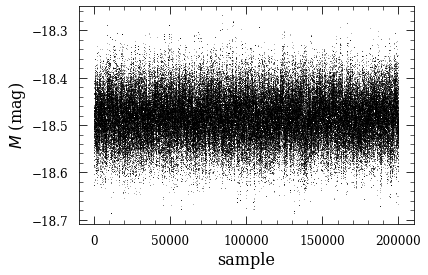

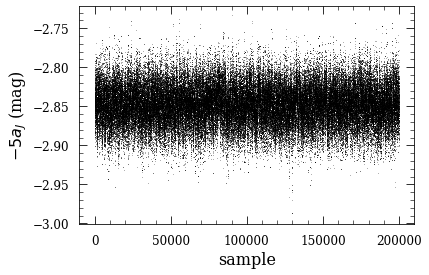

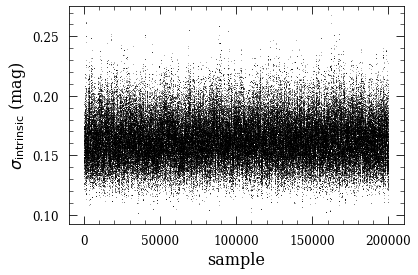

In [20]:
#contains parts of code from Suhail's github repo at https://github.com/sdhawan21/irh0
# plot the samples
samples = sampler.chain[:, nburn:, :].reshape((-1, 3)) #does not plot H0 to keep blind

# calculate -5*a_J
aj5m = -5.*np.log10(samples[:,0]) + samples[:,1] + 25
samples = np.insert(samples,2,aj5m,axis=1)

slabels = [r"$H_0$ (km s$^{-1}$ Mpc$^{-1}$)", 
           r"$M$ (mag)",
           r"$-5 a_J$ (mag)",
           "",
           r"$\sigma_{\mathrm{intrinsic, hflow}}$ (mag)" ]


slabels[3] = r"$\sigma_{\mathrm{intrinsic}}$ (mag)"

for i in range(1,4):  #does not plot H0 to keep blind
    plt.plot(samples[:,i],marker=',',linestyle='None',color='k',alpha=0.3)
    plt.xlabel("sample",fontsize=16)
    plt.ylabel(slabels[i],fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

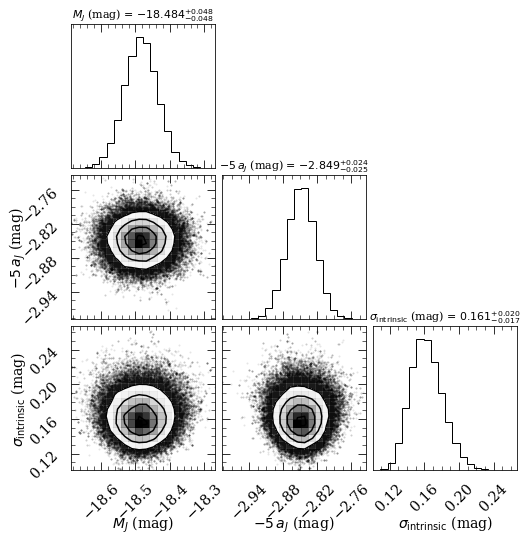

In [21]:
#contains parts of code from Suhail's github repo at https://github.com/sdhawan21/irh0
# make corner plot showing parameter distributions and covariances
tlabels = [r"$H_0$ (km s$^{-1}$ Mpc$^{-1}$)", 
           r"$M_J$ (mag)",
           r"$-5\,a_J$ (mag)",
           "",
           r"$\sigma_{\mathrm{int, hflow}}$ (mag)" ]

tlabels[3] = r"$\sigma_{\mathrm{intrinsic}}$ (mag)"

figcorner = corner.corner(samples[:,1:4], labels=tlabels[1:4], #does not plot for H0 to keep value blind
                    show_titles=True, title_fmt=".3f", verbose=True,
                    title_kwargs={"fontsize": 11}, label_kwargs={"fontsize": 14})

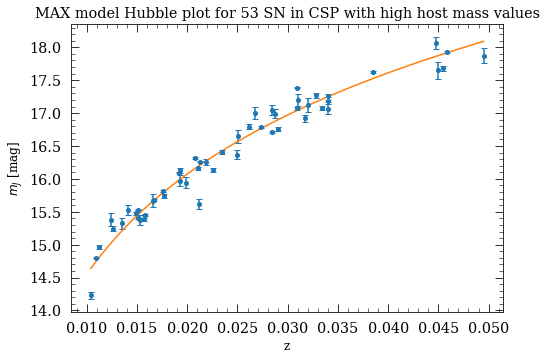

In [22]:
#example Hubble plot for MAX_model CSP high mass data
plt.figure(1).add_axes((0,0,1,1))
smooth_xvals=np.linspace(min(plane(inputs)[1]), max(plane(inputs)[1]), 1000)
ybestfit=model_function(smooth_xvals,2.849/5) #best fit taken from corner plot value, change if fitting something else
plt.errorbar(plane(inputs)[1],plane(inputs)[2],yerr=plane(inputs)[3],fmt='o',capsize=3,ms=4)
plt.plot(smooth_xvals,ybestfit)
#plt.plot(smooth_xvals,ybestfit_low,color='orange')
plt.title('MAX model Hubble plot for 53 SN in CSP with high host mass values')
plt.xlabel("z")
plt.ylabel("$m_{J}$ [mag]")
plt.show()